# MIIII

In [1]:
import jax, optax, yaml
import jax.numpy as jnp
from jax import jit, random, tree_util
from jax.lib import xla_client
from functional import partial
from tqdm import tqdm
import numpy as np
import tikz


from src.data import data_fn
from src.model import init_fn, apply_fn
import esch

In [2]:
with open("config.yaml", "r") as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
rng, key = random.split(random.PRNGKey(0))
opt = optax.lion(conf["lr"], weight_decay=conf["weight_decay"])
params = init_fn(key, conf)
state = opt.init(params)
x, y = data_fn(conf)

In [4]:
def loss_fn(params, x, y):  # todo: weight by prime frquency
    y_pred = apply_fn(params, x)
    loss = jnp.square(y_pred - y).mean()
    return loss

In [5]:
@jit
def update_fn(params, state, x, y):
    loss, grads = jax.value_and_grad(loss_fn)(params, x, y)
    updates, state = opt.update(grads, state, params)
    params = optax.apply_updates(params, updates)
    return params, state, loss

In [6]:
pbar = tqdm(range(conf["epochs"]))
losses = jnp.zeros(conf["epochs"])
for epoch in pbar:
    params, state, loss = update_fn(params, state, x, y)
    losses = losses.at[epoch].add(loss)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 35.28it/s]


In [7]:
info = dict(title="Training curves", xlab="Epoch", ylab="MSE")
fig = esch.curves_fn([losses, losses - 0.01, losses + 0.01, losses + 0.02], info)
fig.show()

## Figures

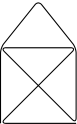

In [5]:
# define coordinates as a list of tuples
from tikz import Picture, line

coords = [(0, 0), (0, 2), (1, 3.25), (2, 2), (2, 0), (0, 2), (2, 2), (0, 0), (2, 0)]

# create `Picture` object
pic = Picture()
# draw a line following the coordinates
pic.draw(line(coords), thick=True, rounded_corners="4pt")
pic

In [9]:
def box_fn(width, height, x, y, label=""):
    coords = [(x, y), (x, y + height), (x + width, y + height), (x + width, y), (x, y)]
    return line(coords)

In [22]:
# make mlp in -> activation -> out diagram with tikz
from tikz import Picture, line, node


def draw_rounded_box(width, height, x, y, label=""):
    coords = [(x, y), (x, y + height), (x + width, y + height), (x + width, y), (x, y)]
    box = line(coords, thick=True, rounded_corners="10pt")
    text = node(x + width / 2, y + height / 2, label, center=True)
    return box, text


pic = Picture()
input_box, input_label = draw_rounded_box(2, 1, 0, 0, "Input")
output_box, output_label = draw_rounded_box(2, 1, 0, 2, "Output")
pic.draw(input_box)
pic.draw(output_box)
pic.draw(line([(1, 0), (1, 1)]), position=node(0.5, 0, "Activation", above=True))
pic.draw(input_label)
pic.draw(output_label)

# Render the picture (you need to install the tikz package for this to work)
pic.writeTikZ("mlp_diagram.tex")
pic

TypeError: line.__init__() got an unexpected keyword argument 'thick'